## 使用模型

In [1]:
import torch
import sys
sys.path.append("../model")
# from basicamt import BasicAMT_all
model = torch.load("basicamt_model.pth", map_location=torch.device('cpu'))
s_per_frame = 256 / 22050

C:\Users\liyon\AppData\Local\Temp\ipykernel_15520\1692518933.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("basicamt_model.pth", map_location=torch.

Sample rate: 22050
Channels: 2
Sample width: 2
Number of frames: 2902528
Duration (s): 131.63392290249433
data num: 5805056


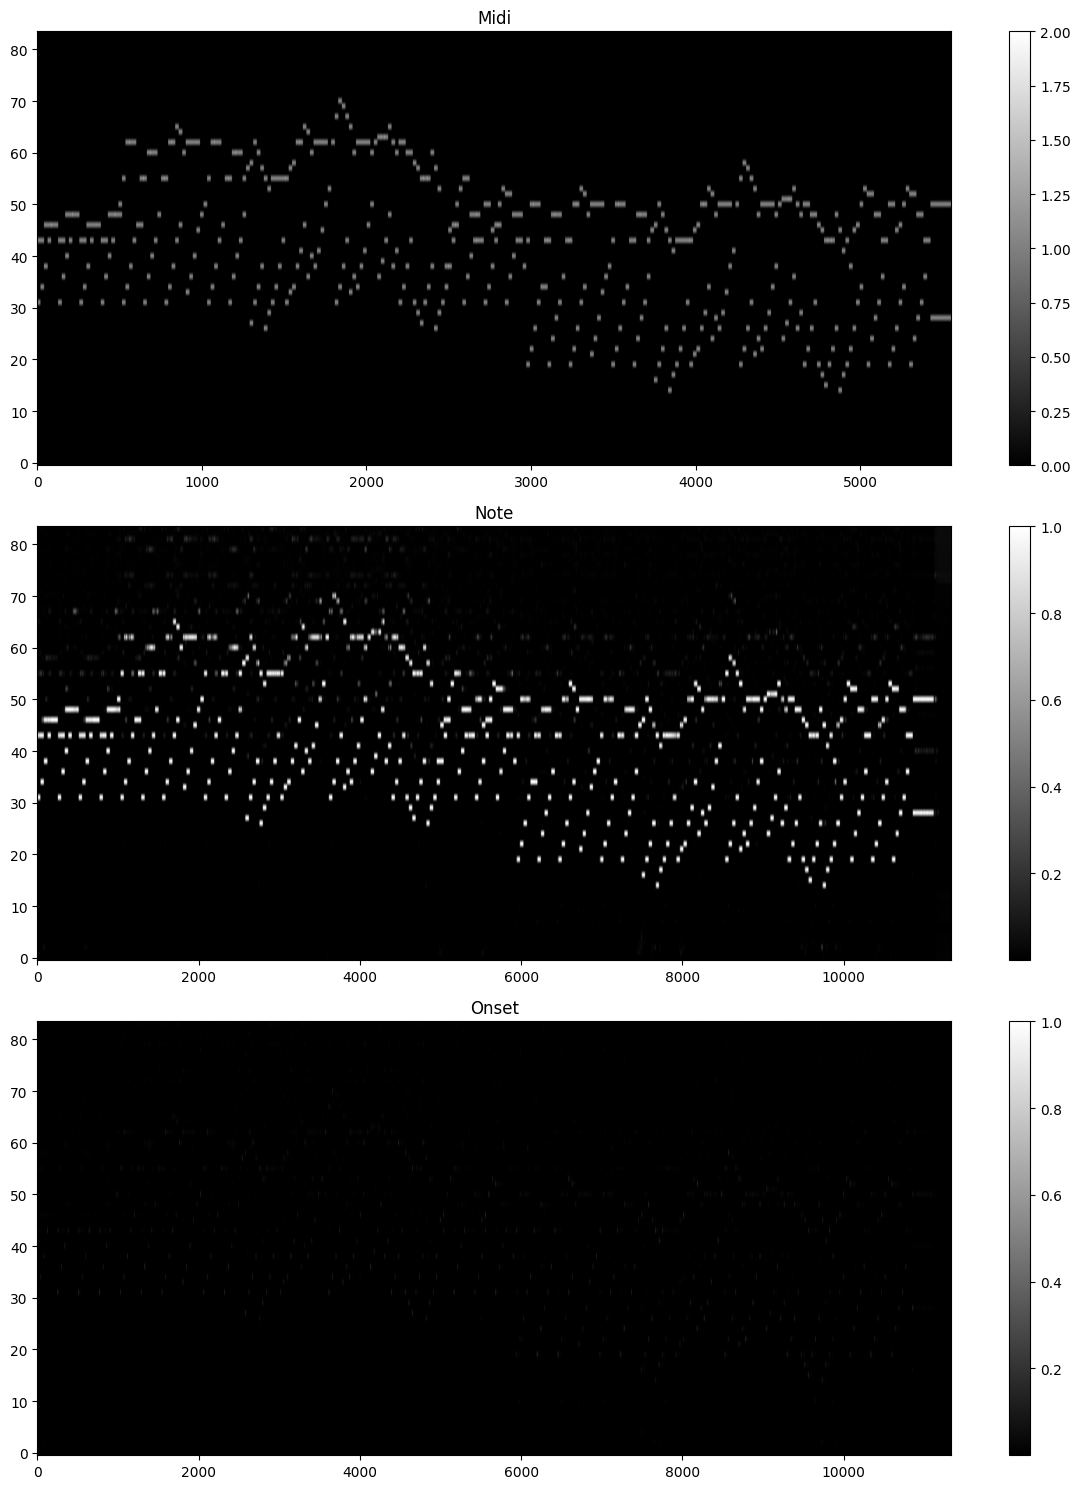

In [2]:
import torchaudio
from utils.midiarray import midi2numpy
from utils.wavtool import waveInfo
import matplotlib.pyplot as plt
import numpy as np
import os

input_wav_path = "../data/inferMusic/孤独な巡礼simple.wav"

audio_name = os.path.basename(input_wav_path).split('.')[0]

try:    # 尝试加载同一目录下同名midi文件
    midi_path = os.path.join(os.path.dirname(input_wav_path), audio_name + '.mid')
    midi_array = midi2numpy(midi_path, s_per_frame)
except:
    midi_array = None

# 降采样
wav_path = f"{audio_name}_22050.wav"
os.system(f'ffmpeg -i "{input_wav_path}" -vn -ar 22050 -y "{wav_path}"')
waveInfo(wav_path)

waveform, sample_rate = torchaudio.load(input_wav_path, normalize=True)
waveform = waveform.unsqueeze(0)

model.eval()
with torch.no_grad():
    onset, note = model(waveform)
    onset = onset.cpu().numpy()[0]
    note = note.cpu().numpy()[0]
    # 归一化
    note = note / np.max(note)
    onset = onset / np.max(onset)

if midi_array is None:
    plot_num = 2
    plt.figure(figsize=(12, plot_num * 5))
else:
    plot_num = 3
    plt.figure(figsize=(12, plot_num * 5))
    plt.subplot(plot_num, 1, 1)
    plt.title('Midi')
    plt.imshow(midi_array, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

plt.subplot(plot_num, 1, plot_num - 1)
plt.title('Note')
plt.imshow(note, aspect='auto', origin='lower', cmap='gray')
plt.colorbar()

plt.subplot(plot_num, 1, plot_num)
plt.title('Onset')
plt.imshow(onset, aspect='auto', origin='lower', cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
np.save("note.npy", note)
np.save("onset.npy", onset)
plt.imsave("note.png", note, origin='lower', cmap='gray')
plt.imsave("onset.png", onset, origin='lower', cmap='gray')

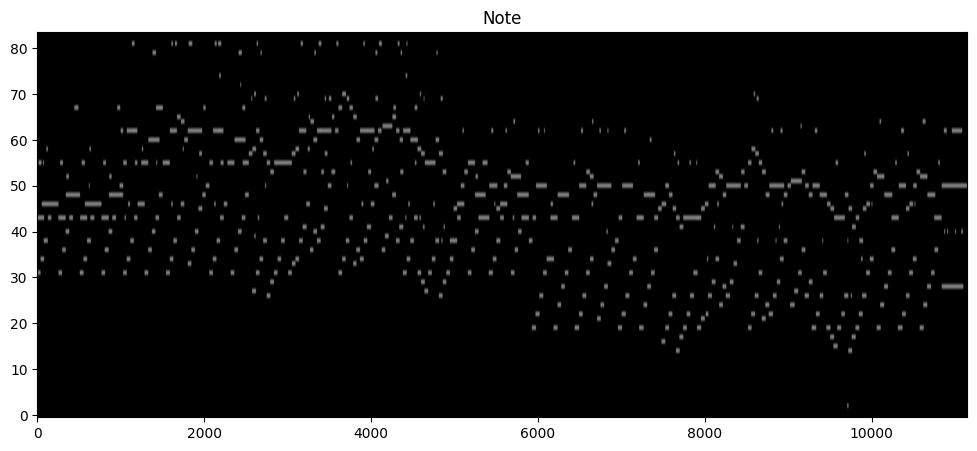

In [3]:
# import importlib
# importlib.reload(sys.modules['utils.postprocess'])
# importlib.reload(sys.modules['utils.midiarray'])
# 二值化
from utils.midiarray import output2midi, midi2numpy

mid = output2midi(onset, note, s_per_frame, 0.14, 0.4)
npmidi = midi2numpy(mid, s_per_frame)

plt.figure(figsize=(12, 5))
plt.title('Note')
plt.imshow(npmidi, aspect='auto', origin='lower', cmap='gray')
plt.show()
mid.save(f"{audio_name}.mid")